## Importing Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean, absolute, sqrt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [43]:
dataset_train = pd.read_csv('train.csv', index_col = "Id")
#dataset_test = pd.read_csv('test.csv')

print(dataset_train.shape)
print(dataset_train.columns)

# The training dataset includes 1460 samples, 79 features, and 1 response

(1460, 80)
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Paved

## Visualizing Data

λ =  1.8829


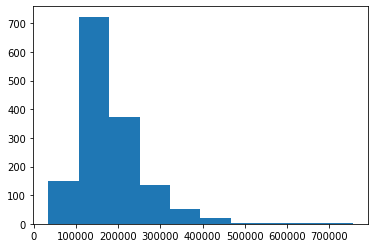

In [44]:
price = dataset_train.iloc[:,79]
plt.hist(price)
print("\u03BB = ", round(price.skew(),4))
plt.show()

λ =  0.1213


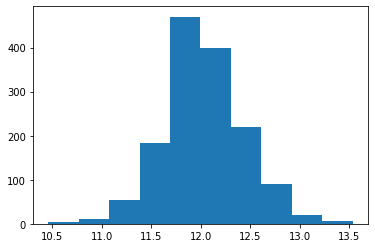

In [45]:
plt.hist(np.log(price))
print("\u03BB = ", round(np.log(price).skew(),4))
plt.show()

## EDA

<AxesSubplot:>

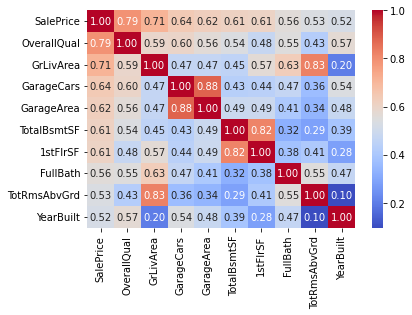

In [46]:
#heatmap
import seaborn as sns
train_data = dataset_train.iloc[:,1:79]
train_data.insert(0,"SalePrice",dataset_train.iloc[:,79],True)


all_numVar = train_data.loc[:,train_data.dtypes != object]
cor_numVar = all_numVar.corr()

cor_numVar = cor_numVar.sort_values(by='SalePrice', ascending = False, axis=1)
cor_numVar = cor_numVar.sort_values(by='SalePrice', ascending = False, axis=0)


cor_numVar = cor_numVar.iloc[:10,:10]
sns.heatmap(cor_numVar, cmap='coolwarm', fmt='.2f', annot=True)

In [47]:
price = dataset_train["SalePrice"]
#all = pd.concat([dataset_train, dataset_test]).iloc[:,0:78]
print(dataset_train.dtypes[0:2])
#second column MSSubClass is categorical feature but is considered as 
#int so we remapped it

dataset_train["MSSubClass"] = dataset_train["MSSubClass"].astype(str)
dataset_train["MSSubClass"] = dataset_train["MSSubClass"].replace(["20","30","40","45","50","60","70","75","80","85","90","120","150"
                           , "160","180","190"], ["1-story_1946+","1-story_1945-", "1-story_with_finished_attic"
                           ,"1.5_story_unifinished", "1.5_finished", "2-story_1946+", "2-story_1945-",
                            "2.5_story", "split_or_multi_level", "split_foyer", "1-story_PUD",  "duplex",
                            "1.5_story_PUD", "2-story_PUD", "PUD_Multilevel","2_family_conversion"])
dataset_train["MSSubClass"].head()

MSSubClass     int64
MSZoning      object
dtype: object


Id
1    2-story_1946+
2    1-story_1946+
3    2-story_1946+
4    2-story_1945-
5    2-story_1946+
Name: MSSubClass, dtype: object

In [48]:
#modify yrs
#YearBuilt: Original construction date
#YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
#YrSold: Year Sold (YYYY)

# remodel 0 = no 1 =yes
# age: yr-sold - max(yearbulit, yearromodadd)

remod = dataset_train["YearBuilt"] == dataset_train["YearRemodAdd"]


remod = np.multiply(np.array(remod),1)
        
#HouseAge = all["YearBuilt"] - max(all["YearBuilt"], all["YearRemodAdd"])

HouseAge = dataset_train["YrSold"] - dataset_train[["YearBuilt", "YearRemodAdd"]].max(axis=1)
print(min(HouseAge))

dataset_train["HouseAge"] = HouseAge
dataset_train["remod"] = remod
dataset_train = dataset_train.drop(columns=["YearBuilt","YearRemodAdd","YrSold" ])
dataset_train.head()


-1


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,remod
Id,,,,,,,,,,,,,,,,,,,,,
1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,WD,Normal,208500,5,1
2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,WD,Normal,181500,31,1
3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,WD,Normal,223500,6,0
4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,WD,Abnorml,140000,36,0
5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,WD,Normal,250000,8,1


In [49]:
#BsmtFullBath: Basement full bathrooms
#BsmtHalfBath: Basement half bathrooms
#FullBath: Full bathrooms above grade
#HalfBath: Half baths above grade

#A full bathroom is made up of four parts: a sink, a shower, a bathtub, and a toilet. Anything less than that, and you can't officially consider it a full bath
#A bathroom with just a sink and a toilet is a half-bath.

dataset_train['BsmtFullBath']  = dataset_train['BsmtFullBath'].fillna(0)
dataset_train['BsmtHalfBath']  = dataset_train['BsmtHalfBath'].fillna(0)

dataset_train['NumBath'] = dataset_train['BsmtFullBath'] + dataset_train['BsmtHalfBath'] *.5 + dataset_train['HalfBath'] + dataset_train['HalfBath'] * .5

dataset_train = dataset_train.drop(columns=['BsmtFullBath','BsmtHalfBath','HalfBath','HalfBath' ])

dataset_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,remod,NumBath
Id,,,,,,,,,,,,,,,,,,,,,
1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,WD,Normal,208500,5,1,2.5
2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,WD,Normal,181500,31,1,0.5
3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,WD,Normal,223500,6,0,2.5
4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,WD,Abnorml,140000,36,0,1.0
5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,WD,Normal,250000,8,1,2.5


In [50]:
#garage variables

#price

dataset_train['GarageArea']  = dataset_train['GarageArea'].fillna(0)
dataset_train['GarageCars']  = dataset_train['GarageCars'].fillna(0)

cor_Garage_area_cars = dataset_train['GarageArea'].corr(dataset_train['GarageCars'])
print("Since GarageArea and GarageCars are highly correlated (cor = ", round(cor_Garage_area_cars,4), ")\n")
print("in case of parsimony, we choose one that has a higher correlation with SalePrice")

print("correlation between GarageArea and SalePrice is", round(dataset_train['GarageArea'][0:1459].corr(price),4))
print("correlation between GarageCars and SalePrice is", round(dataset_train['GarageCars'][0:1459].corr(price),4))
print("Therefore we keep the GarageCars variable")

dataset_train = dataset_train.drop(columns=['GarageArea' ])

dataset_train.head()

Since GarageArea and GarageCars are highly correlated (cor =  0.8825 )

in case of parsimony, we choose one that has a higher correlation with SalePrice
correlation between GarageArea and SalePrice is 0.6234
correlation between GarageCars and SalePrice is 0.6404
Therefore we keep the GarageCars variable


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,remod,NumBath
Id,,,,,,,,,,,,,,,,,,,,,
1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,WD,Normal,208500,5,1,2.5
2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,WD,Normal,181500,31,1,0.5
3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,WD,Normal,223500,6,0,2.5
4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,WD,Abnorml,140000,36,0,1.0
5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,WD,Normal,250000,8,1,2.5


In [51]:
#x1stFlrSF and totalbasement
#x1stF   + 2nd = grlivarea

df_test1 = dataset_train[['1stFlrSF', '2ndFlrSF', 'GrLivArea']]
df_test1['sum1and2'] = df_test1['1stFlrSF'] + df_test1['2ndFlrSF']
df_test1['DiffSumAndTot'] = df_test1['GrLivArea'] - df_test1['sum1and2'] 
print(df_test1[1:20])

print("we can see there are only", sum((dataset_train['1stFlrSF'] + dataset_train['2ndFlrSF']) != dataset_train['GrLivArea']) ,"out of 2919 data sets, approximately 1% of total data set\n",
      "that first floor area + second floor area != totol above ground living area, probably there are some houses has\n",
      "> 2 floors that has not been taken into account of the dataset")
print("so we comes to the conclusion that Total above ground living area('GrLivArea') explains both two variables\n")
print("first floor sf and second floor sq")
print("so we drop those two features")

dataset_train = dataset_train.drop(columns=['1stFlrSF','2ndFlrSF' ])

dataset_train.head()

    1stFlrSF  2ndFlrSF  GrLivArea  sum1and2  DiffSumAndTot
Id                                                        
2       1262         0       1262      1262              0
3        920       866       1786      1786              0
4        961       756       1717      1717              0
5       1145      1053       2198      2198              0
6        796       566       1362      1362              0
7       1694         0       1694      1694              0
8       1107       983       2090      2090              0
9       1022       752       1774      1774              0
10      1077         0       1077      1077              0
11      1040         0       1040      1040              0
12      1182      1142       2324      2324              0
13       912         0        912       912              0
14      1494         0       1494      1494              0
15      1253         0       1253      1253              0
16       854         0        854       854             

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,remod,NumBath
Id,,,,,,,,,,,,,,,,,,,,,
1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,WD,Normal,208500,5,1,2.5
2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,WD,Normal,181500,31,1,0.5
3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,WD,Normal,223500,6,0,2.5
4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,WD,Abnorml,140000,36,0,1.0
5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,WD,Normal,250000,8,1,2.5


In [52]:
print("since Total # of rooms and above ground living area are highly correlated, cor = ", round(dataset_train['TotRmsAbvGrd'].corr(dataset_train['GrLivArea']),4))
print("so we choose one has higher correlation with SalePrice")
dataset_train = dataset_train.drop(columns=['TotRmsAbvGrd' ])
dataset_train.head()



since Total # of rooms and above ground living area are highly correlated, cor =  0.8255
so we choose one has higher correlation with SalePrice


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,remod,NumBath
Id,,,,,,,,,,,,,,,,,,,,,
1,2-story_1946+,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,WD,Normal,208500,5,1,2.5
2,1-story_1946+,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,WD,Normal,181500,31,1,0.5
3,2-story_1946+,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,WD,Normal,223500,6,0,2.5
4,2-story_1945-,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,WD,Abnorml,140000,36,0,1.0
5,2-story_1946+,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,WD,Normal,250000,8,1,2.5


<AxesSubplot:>

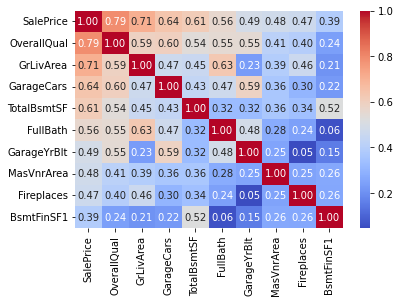

In [53]:
train_data = dataset_train.iloc[0:1460,1:71]
#train_data.insert(0,"SalePrice",price,True)
numericVars = dataset_train.dtypes != 'O' #find numeric vars

all_numVar = train_data.loc[:,train_data.dtypes != object]
cor_numVar = all_numVar.corr()


cor_numVar = cor_numVar.sort_values(by='SalePrice', ascending = False, axis=1)
cor_numVar = cor_numVar.sort_values(by='SalePrice', ascending = False, axis=0)


cor_numVar = cor_numVar.iloc[:10,:10]
sns.heatmap(cor_numVar, cmap='coolwarm', fmt='.2f', annot=True)

In [54]:
# replacing all missing values by the corresponding feature’s mean. 
# Then, to put all features on a common scale, 
# we standardize the data by rescaling features to zero mean and unit variance
# Intuitively, we standardize the data for two reasons. 
# First, it proves convenient for optimization. 
# Second, because we do not know a priori which features will be relevant,
# we do not want to penalize coefficients assigned to one feature 
# more than on any other.


# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = dataset_train.dtypes[dataset_train.dtypes != 'object'].index
dataset_train[numeric_features] = dataset_train[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
dataset_train[numeric_features] = dataset_train[numeric_features].fillna(0)

In [55]:
# Next we deal with discrete values. 
# We replace them by a one-hot encoding
# Dummy variables
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
dataset_train = pd.get_dummies(dataset_train, dummy_na=True)
dataset_train.shape


(1460, 340)

In [56]:
dataset_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.207948,-0.207071,0.651256,-0.517023,0.509840,0.575228,-0.288554,-0.944267,-0.459145,-0.120201,...,0,1,0,0,0,0,0,1,0,0
2,0.409724,-0.091855,-0.071812,2.178881,-0.572637,1.171591,-0.288554,-0.641008,0.466305,-0.120201,...,0,1,0,0,0,0,0,1,0,0
3,-0.084413,0.073455,0.651256,-0.517023,0.322063,0.092875,-0.288554,-0.301540,-0.313261,-0.120201,...,0,1,0,0,0,0,0,1,0,0
4,-0.413838,-0.096864,0.651256,-0.517023,-0.572637,-0.499103,-0.288554,-0.061648,-0.687089,-0.120201,...,0,1,0,1,0,0,0,0,0,0
5,0.574436,0.375020,1.374324,-0.517023,1.360357,0.463410,-0.288554,-0.174805,0.199611,-0.120201,...,0,1,0,0,0,0,0,1,0,0


In [57]:
#test = all_features.iloc[1460:,]
#test

In [58]:
#split data into categorical and continuous variables for analysis
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_cont = dataset_train.head().select_dtypes(include=numerics)
df_cat = dataset_train.head().select_dtypes(include = 'object')

## Lasso for Feature Selection 

In [59]:
#df = pd.concat([train, np.log(dataset_train['SalePrice'])], axis = 1)
df = dataset_train

In [60]:
#Using lasso to eliminate some features
X_lasso = df.loc[:, df.columns != 'SalePrice']
y = df['SalePrice']

from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

cv = KFold(n_splits=10, shuffle=True, random_state=10)
model = LassoCV(cv=cv)
lassocv = model.fit(X_lasso, y)

B_lasso = lassocv.coef_
B_lasso = np.insert(B_lasso, 0, lassocv.intercept_, axis=0)

print('The Coef are')
print(B_lasso)
#print('\nlambda best is = %f' % lassocv.alpha_)

The Coef are
[-4.91317750e-01 -2.30029126e-03  4.20607076e-02  1.67411696e-01
  6.57077934e-02  4.05905350e-02  4.74162892e-02  2.97249667e-03
 -0.00000000e+00  3.95651629e-02 -1.99042863e-02  3.30650270e-01
  5.20034392e-02 -1.67049609e-02 -2.61019025e-02  2.85095427e-02
  2.43310174e-02  8.69185576e-02  2.72723685e-02 -6.33729467e-04
 -2.84165036e-03  7.64728104e-03  2.48056365e-02  1.71988988e-02
 -0.00000000e+00 -9.73966647e-03 -1.68858293e-02 -2.28234219e-03
  3.95266380e-02  0.00000000e+00  5.04958736e-02  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -4.62508773e-02 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.48146933e-03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.01345750e-02  0.00000000e+00  0.00000000e+00
  1.63414449e-02 -3.64304861e-02  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  1.90042269e-02 -0.00000000e+00
 -0.00000000

In [61]:
df_lasso =  df.loc[:, df.columns != 'SalePrice'] * lassocv.coef_
df_lasso.shape

(1460, 339)

In [62]:
df_lasso = df_lasso.loc[:, (df != 0).any(axis=0)]
df_lasso.shape

(1460, 311)

In [63]:
df1 = pd.concat([df_lasso, dataset_train['SalePrice']], axis = 1)
df1.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,0.000478,-0.008710,0.109028,-0.033972,0.020695,0.027275,-0.000858,0.0,-0.018166,0.002393,...,0.0,0.0,-0.03035,-0.000000,0.0,0.0,-0.0,0.0,0.0,0.347154
2,-0.000942,-0.003863,-0.012022,0.143169,-0.023244,0.055552,-0.000858,0.0,0.018449,0.002393,...,0.0,0.0,-0.03035,-0.000000,0.0,0.0,-0.0,0.0,0.0,0.007286
3,0.000194,0.003090,0.109028,-0.033972,0.013073,0.004404,-0.000858,0.0,-0.012394,0.002393,...,0.0,0.0,-0.03035,-0.000000,0.0,0.0,-0.0,0.0,0.0,0.535970
4,0.000952,-0.004074,0.109028,-0.033972,-0.023244,-0.023666,-0.000858,0.0,-0.027185,0.002393,...,0.0,0.0,-0.03035,-0.074582,0.0,0.0,-0.0,0.0,0.0,-0.515105
5,-0.001321,0.015774,0.230078,-0.033972,0.055218,0.021973,-0.000858,0.0,0.007898,0.002393,...,0.0,0.0,-0.03035,-0.000000,0.0,0.0,-0.0,0.0,0.0,0.869545


## Regressions

In [64]:
# 10-Fold Cross Validation

def cross_validation (df, func):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 10, shuffle = True, random_state = 10)
    kf_rmse = []
    
    for train, test in kf.split(df):
        X_train = df.iloc[train].loc[:, df.columns != 'SalePrice']
        X_train = X_train.squeeze()
        X_test = df.iloc[test].loc[:, df.columns != 'SalePrice']
        y_train = df.iloc[train].loc[:,'SalePrice']
        y_test = df.iloc[test].loc[:,'SalePrice']
        
        reg = func.fit(X_train, y_train)
        y_hat = reg.predict(X_test)
        
        from sklearn.metrics import mean_squared_error
        kf_rmse.append(mean_squared_error(y_test, y_hat, squared=False))
        
    kf_RMSE = (1/10) * np.sum(kf_rmse)
        
    return (kf_RMSE)

In [65]:
y = df1["SalePrice"]
X = df1.drop("SalePrice", axis = 1)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [66]:
#Check which one produces higher R2 score and lower cv-rmse
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

y_hat = model.predict(X)

from sklearn.metrics import mean_squared_error
model_train_rmse = mean_squared_error(y, y_hat, squared=False)
#score = model.score(x, y)
#print(model_train_rmse)
model_cv_rmse = cross_validation(df1,LinearRegression())

Text(0, 0.5, 'Predicted Value')

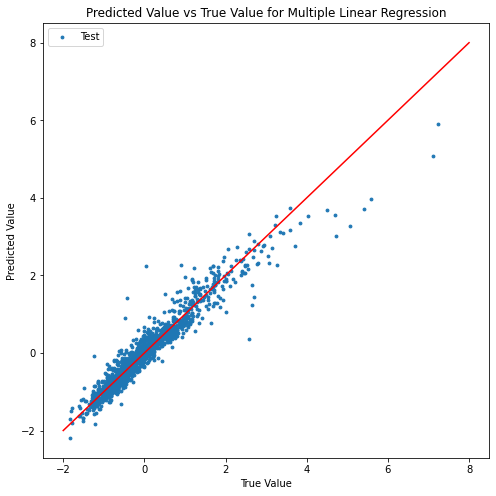

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(x = y, y = y_hat, s = 8, label = "Test")
#plt.scatter(x = np.exp(y_train), y = np.exp(ols.predict(X_train)), s = 8, label = "Train")
plt.plot([-2,8],[-2,8], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Multiple Linear Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Ensemble Methods

### Random Forest

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [69]:
randomForest = RandomForestRegressor(random_state = 0)

In [70]:
grid_para_forest = {'n_estimators': [100,500,1000,2500,5000],
                   'max_depth': [10,15,20,30,40,50],
                   'max_features' : [5,7,15]}

In [71]:
grid_search_forest = GridSearchCV(randomForest, 
                                  grid_para_forest,
                                  cv=10, n_jobs = 5, verbose = 1)
grid_search_forest.fit(X, y)

print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)
print(grid_search_forest.best_estimator_)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
{'max_depth': 20, 'max_features': 15, 'n_estimators': 500}
0.8580934205088628
RandomForestRegressor(max_depth=20, max_features=15, n_estimators=500,
                      random_state=0)


In [72]:
bestmodel_rf = grid_search_forest.best_estimator_
pred_rf = bestmodel_rf.predict(X)
#RMSLE = np.sqrt(mean_squared_log_error(pred_rf, y_test))
#print("RMSLE: " + str(round(RMSLE,5)))

Text(0, 0.5, 'Features')

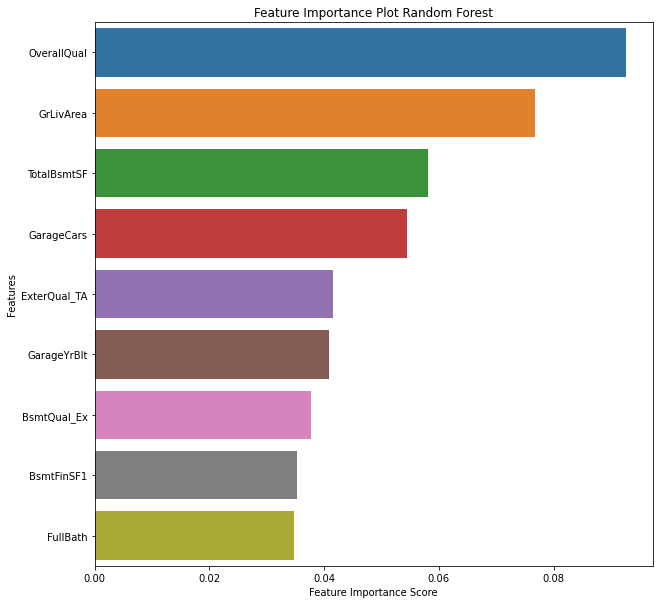

In [73]:
sorted_importance = sorted(list(zip(X.columns, bestmodel_rf.feature_importances_)), key=lambda t:t[1], reverse=True)
a, b = list(zip(*sorted_importance))
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df[0:9], x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Plot Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

Text(0, 0.5, 'Predicted Value')

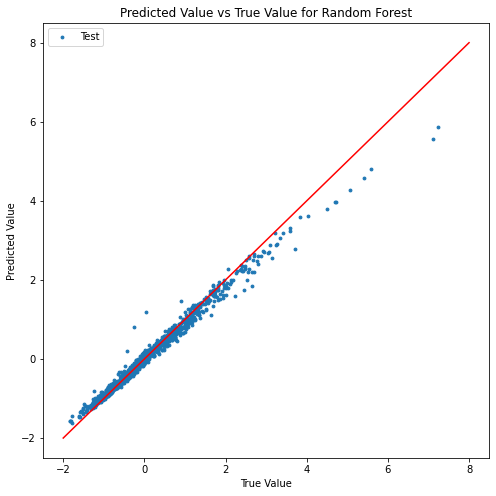

In [74]:
plt.figure(figsize=(8,8))
#plt.scatter(x = y_test, y = pred_rf, s = 8, label = "Test")
plt.scatter(x = y, y = pred_rf, s = 8, label = "Test")
#plt.scatter(x = y_train, y = bestmodel_rf.predict(X_train), s = 8, label = "Train")
plt.plot([-2,8],[-2,8], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Random Forest")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

In [75]:
model2_train_rmse = mean_squared_error(y, pred_rf, squared=False)
#score = model.score(x, y)
#print(model_train_rmse)
model2_cv_rmse = cross_validation(df1,bestmodel_rf)

### Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state = 0)

In [77]:
grid_para_gb = {'n_estimators': [100,500,1000,2500,5000],
                   'learning_rate':[0.01,0.05,0.1],
                   'max_depth':range(1,6),
                   'max_features' : [5,7,15]}

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV
grid_search_gb = GridSearchCV(gbm, grid_para_gb, cv=5, n_jobs = 5, verbose = 1)
grid_search_gb.fit(X, y)

print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 15, 'n_estimators': 1000}
0.9048259023937893
GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features=15,
                          n_estimators=1000, random_state=0)


In [79]:
bestmodel_gb = grid_search_gb.best_estimator_
pred_gb = bestmodel_gb.predict(X)

Text(0, 0.5, 'Predicted Value')

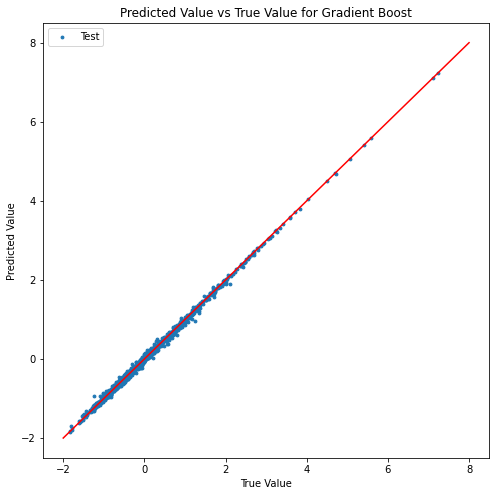

In [80]:
plt.figure(figsize=(8,8))
#plt.scatter(x = y_test, y = pred_rf, s = 8, label = "Test")
plt.scatter(x = y, y = pred_gb, s = 8, label = "Test")
#plt.scatter(x = y_train, y = bestmodel_rf.predict(X_train), s = 8, label = "Train")
plt.plot([-2,8],[-2,8], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Gradient Boost")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

In [81]:
model3_train_rmse = mean_squared_error(y, pred_gb, squared=False)
score = model.score(X, y)
print(score)
model3_cv_rmse = cross_validation(df1,bestmodel_gb)

0.9207278377800758


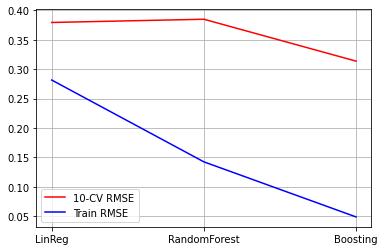

In [82]:
x = ['LinReg', 'RandomForest', 'Boosting']
y1 = [model_train_rmse, model2_train_rmse, model3_train_rmse]
y2 = [model_cv_rmse, model2_cv_rmse, model3_cv_rmse]

plt.plot(x, y2, label = "10-CV RMSE", c='r')
plt.plot(x, y1, label = "Train RMSE", c='b')
plt.legend()
plt.grid()
plt.show()